In [1]:
from Binaries import *

-8/2401 /cr/tempdata01/filip/iRODS/corrected/peru_randoms0793.csv: 5000 traces


StopIteration: 

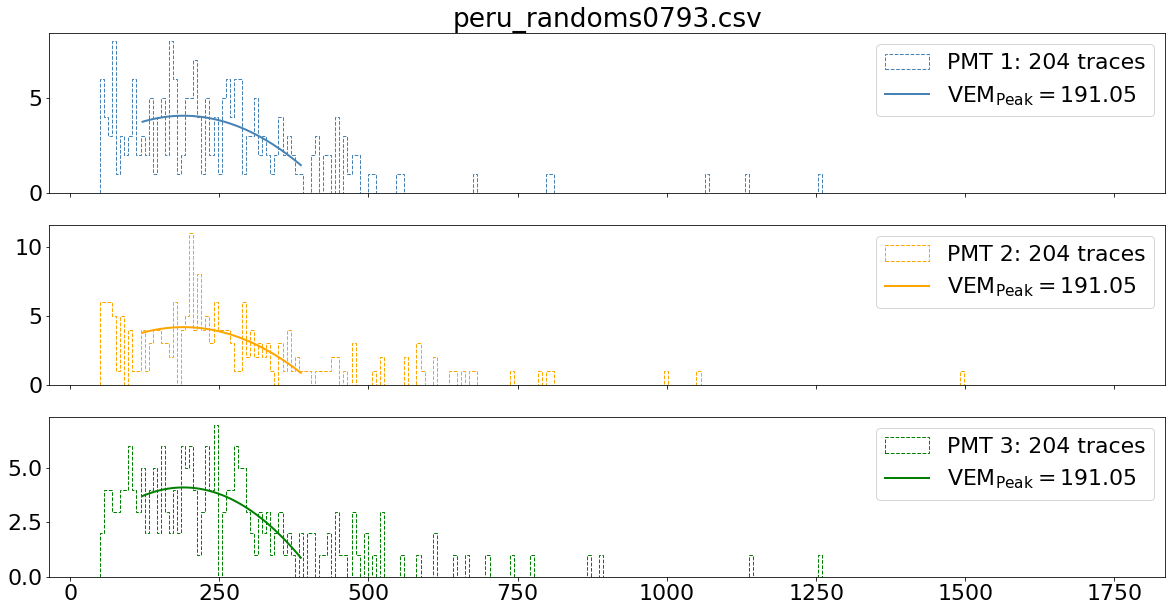

In [7]:
peak_evolution = []
cut_threshold = 50
trailing_bins = 40
leading_bins = 10

from scipy.optimize import curve_fit
# from scipy.stats import norm

# def gauss(x, A, mu, sigma):

#     return A * np.exp( (x - mu)**2 / (2 * sigma**2) )

def parabola(x, vem_peak, scale, offset):

    return scale * (x - vem_peak)**2 + offset

colors = ["steelblue", "orange", "green"]

vem_lower = {

    "nuria" : 160,
    "lo_qui_don" : 155,
    "peru" : 150,
    "jaco" : 150
}

vem_upper = {

    "nuria" : 190,
    "lo_qui_don" : 180,
    "peru" : 190,
    "jaco" : 220
}


for index in [-8]:

    try:

        Buffer = RandomTrace(index)
        h1, h2, h3 = [], [], []
        vem_peak = []

        print(f"{index}/{RandomTrace.all_n_files} {RandomTrace.baseline_dir + RandomTrace.all_files[index]}: {len(Buffer._these_traces)} traces" )

        fig, axes = plt.subplots(3, 1, sharex = True)
        axes[0].set_title(RandomTrace.all_files[index])
        name = RandomTrace.all_files[index].split("_")[0]

        station = np.array(Buffer._these_traces)
        pmt1, pmt2, pmt3 = station[:,0], station[:,1], station[:,2]
        cut_mask = np.logical_and(np.any(pmt1 > cut_threshold, axis = 1), np.any(pmt2 > cut_threshold, axis = 1), np.any(pmt3 > cut_threshold, axis = 1))

        for (p1, p2, p3) in zip(pmt1[cut_mask], pmt2[cut_mask], pmt3[cut_mask]):

            trigger_bin = np.argmax(p1 > cut_threshold)
            start = max(0, trigger_bin - leading_bins)
            stop = min(trigger_bin + trailing_bins, 2048)

            p1_data, p2_data, p3_data = p1[start : stop], p2[start : stop], p3[start : stop]

            if np.any(p2_data > cut_threshold) and np.any(p3_data > cut_threshold):

                h1.append(max(p1_data)), h2.append(max(p2_data)), h3.append(max(p3_data))
        
        for i, histogram in enumerate([h1, h2, h3]):

            n, bins, _ = axes[i].hist(histogram,  bins = 250, range = (cut_threshold, 1750), label = f"PMT {i + 1}: {len(histogram)} traces", ls = "--", histtype = "step", color = colors[i])
            bin_centers = 0.5 * (bins[1:] + bins[:-1])

            x, y = bin_centers[10 : 50], n[10 : 50]
            x_smooth = np.linspace(min(x), max(x), 100)

            popt, pcov = curve_fit(parabola, x, y, p0 = [Buffer.q_peak[i], -100, 5], bounds = ([vem_lower[name], -np.inf, -np.inf], [vem_upper[name], 0, np.inf]))
            # model_fit = gauss(x_smooth, A, mu, sigma)



            params = np.polyfit(x, y, 2)
            model_fit = parabola(x_smooth, *popt)
            peak_estimate = x_smooth[np.argmax(model_fit)]


            axes[i].plot(x_smooth, model_fit, lw = 2, label = r"$\mathrm{VEM}_\mathrm{Peak} = $" + f"{peak_estimate:.2f}", c = colors[i])
            axes[i].legend()

            if peak_estimate in [x_smooth[0], x_smooth[-1]]: raise SignalError

            vem_peak.append(peak_estimate)

        peak_evolution.append(vem_peak)

    except SignalError:

        os.system(f"mv {RandomTrace.baseline_dir + RandomTrace.all_files[index]} {'/cr/tempdata01/filip/iRODS/error_estimate/' + RandomTrace.all_files[index]}")
    
    # plt.xlim(cut_threshold, 500)
    raise StopIteration

In [ ]:
print(peak_evolution)

In [ ]:
print(min(x_smooth), max(x_smooth))